In [5]:
# ========================
# IMPORT BEBERAPA PACKAGE
# ========================

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
# ========================
# LOAD DATASET
# ========================

# Dataset ini tidak punya header.
# Nilai seperti 2001 di kolom pertama adalah TARGET (tahun), bukan nama feature /  kolom.

path = "datasets/midterm-regresi-dataset.csv"
if not os.path.exists(path):
    raise FileNotFoundError(f"File not found: {path}")

df = pd.read_csv(path, header=None)
df.rename(columns={0: "target_year"}, inplace=True)

print("Shape:", df.shape)
print("Sample (first 3 rows):")
print(df.iloc[:3, :6])

Shape: (515345, 91)
Sample (first 3 rows):
   target_year         1         2         3         4         5
0         2001  49.94357  21.47114  73.07750   8.74861 -17.40628
1         2001  48.73215  18.42930  70.32679  12.94636 -10.32437
2         2001  50.95714  31.85602  55.81851  13.41693  -6.57898


In [7]:
print("df.shape:", df.shape) #ada 515344 row/baris dan 90 feature

df.shape: (515345, 91)


In [8]:
import os
file_size_bytes = os.path.getsize(path)
file_size_mb = file_size_bytes / (1024 ** 2)

print(f"Ukuran file: {file_size_bytes:,} bytes")
print(f"Ukuran file: {file_size_mb:.2f} MB")  #ukuran 422.88 MB, deadline 2 minggu. ngerjain mepet pasti ga kelar :))))

Ukuran file: 443,423,087 bytes
Ukuran file: 422.88 MB


In [9]:
# ========================
# Inspect missing values and basic stats
# ========================

print("\nTotal missing values in dataset:", df.isna().sum().sum())
print("\nColumn-wise missing (first 20 cols):")
print(df.isna().sum().head(20))
print("\nBasic stats for first 10 columns:")
print(df.describe().T.head(10))


Total missing values in dataset: 0

Column-wise missing (first 20 cols):
target_year    0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
16             0
17             0
18             0
19             0
dtype: int64

Basic stats for first 10 columns:
                count         mean        std         min         25%  \
target_year  515345.0  1998.397082  10.931046  1922.00000  1994.00000   
1            515345.0    43.387126   6.067558     1.74900    39.95469   
2            515345.0     1.289554  51.580351  -337.09250   -26.05952   
3            515345.0     8.658347  35.268585  -301.00506   -11.46271   
4            515345.0     1.164124  16.322790  -154.18358    -8.48750   
5            515345.0    -6.553601  22.860785  -181.95337   -20.66645   
6            515345.0    -9

In [10]:
# ========================
# Split target and features
# ========================

y = df["target_year"].values
X = df.drop(columns=["target_year"]).values

In [11]:
# ========================
# Impute missing values and remove zero-variance features
# ========================

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X_imputed)
kept_indices = vt.get_support(indices=True)
print(f"\nOriginal features: {X.shape[1]}, Kept after variance filter: {X_vt.shape[1]}")


Original features: 90, Kept after variance filter: 90


In [12]:
# ========================
# Scale features
# ========================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vt)

In [13]:
# ========================
# Train-test split
# ========================

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

Train size: (412276, 90) Test size: (103069, 90)


In [14]:
# ========================
# Linear Regression
# ========================

lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
metrics_lr = eval_metrics(y_test, y_lr)
print("\nLinear Regression metrics:", metrics_lr)


Linear Regression metrics: {'MSE': np.float64(90.69347247878291), 'RMSE': np.float64(9.523312054048366), 'MAE': np.float64(6.778168687522766), 'R2': 0.23796616215080735}


In [15]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:
# ========================
# LightGBM Training
# ========================

import lightgbm as lgb

# Dataset for LightGBM
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, label=y_test)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "verbosity": -1
}

gbm = lgb.train(
    params,
    train_set=dtrain,
    num_boost_round=100,
    valid_sets=[dvalid],
    valid_names=["valid"]
)

# Predict
y_pred_lgb = gbm.predict(X_test)
metrics_lgb = eval_metrics(y_test, y_pred_lgb)
print("LightGBM metrics:", metrics_lgb)

LightGBM metrics: {'MSE': np.float64(81.31024800654598), 'RMSE': np.float64(9.017219527467764), 'MAE': np.float64(6.300733168631621), 'R2': 0.31680683679419963}


In [17]:
# ========================
# Simple Keras MLP
# ========================

tf.random.set_seed(42)
input_dim = X_train.shape[1]

mlp = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

history = mlp.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=60,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

# Predict
y_mlp = mlp.predict(X_test).ravel()
metrics_mlp = eval_metrics(y_test, y_mlp)
print("Keras MLP metrics:", metrics_mlp)

Epoch 1/60
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 637667.2500 - mae: 559.8968 - val_loss: 109042.6016 - val_mae: 245.5565
Epoch 2/60
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 53818.6836 - mae: 161.5379 - val_loss: 13169.8350 - val_mae: 75.0236
Epoch 3/60
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3101.9346 - mae: 30.9183 - val_loss: 843.1036 - val_mae: 16.7299
Epoch 4/60
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 438.0144 - mae: 13.1790 - val_loss: 353.5922 - val_mae: 11.1612
Epoch 5/60
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 212.3925 - mae: 9.8095 - val_loss: 256.4318 - val_mae: 10.3497
Epoch 6/60
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 143.8405 - mae: 8.4476 - val_loss: 154.8103 - val_mae: 8.0727
Epoch 7/60
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 124.3266 - mae: 8.0237 - val_loss: 175.7360 - val_mae: 9.4206
Epoch 8/60
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 119.2165 - mae: 7.9395 - val_loss: 185.9463 - v

In [18]:
# ========================
# Compare Results
# ========================

results = pd.DataFrame([
    {"model": "LinearRegression", **metrics_lr},
    {"model": "LightGBM",        **metrics_lgb},
    {"model": "KerasMLP",        **metrics_mlp}
]).set_index("model")

print("\nModel comparison (test set):")
display(results)

best = results["RMSE"].idxmin()
print("\nBest model by RMSE:", best)


Model comparison (test set):


,MSE,RMSE,MAE,R2
model,,,,
LinearRegression,90.693472,9.523312,6.778169,0.237966
LightGBM,81.310248,9.017220,6.300733,0.316807
KerasMLP,103.496654,10.173331,7.215098,0.130390



Best model by RMSE: LightGBM


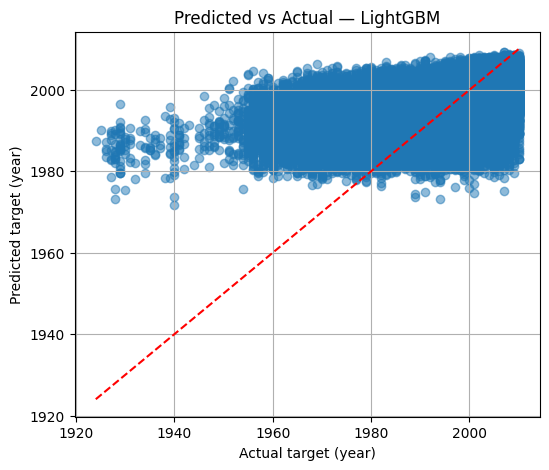

In [19]:
# ========================
# Plot Predicted vs Actual
# ========================

if best == "LinearRegression":
    y_best = y_lr
elif best == "LightGBM":
    y_best = y_pred_lgb
elif best == "KerasMLP":
    y_best = y_mlp
else:
    raise ValueError(f"Unknown best model: {best}")

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--", color="red")
plt.xlabel("Actual target (year)")
plt.ylabel("Predicted target (year)")
plt.title(f"Predicted vs Actual — {best}")
plt.grid(True)
plt.show()


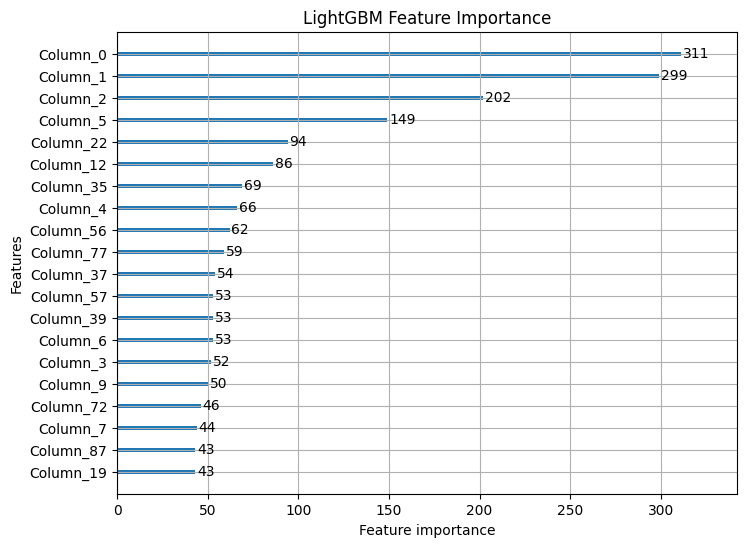

In [20]:
# ========================
# Feature Importance (LightGBM)
# ========================

lgb.plot_importance(gbm, max_num_features=20, figsize=(8,6))
plt.title("LightGBM Feature Importance")
plt.show()
